<a href="https://colab.research.google.com/github/srilav/machinelearning/blob/main/Team_11_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import glob

# Timedelta function demonstration 
import datetime as dt

In [3]:
!pip -qq install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

     |████████████████████████████████| 234 kB 7.8 MB/s 
     |████████████████████████████████| 177 kB 39.8 MB/s 
     |████████████████████████████████| 53.2 MB 2.9 MB/s 
     |████████████████████████████████| 1.2 MB 58.9 MB/s 
     |████████████████████████████████| 125 kB 62.9 MB/s 
     |████████████████████████████████| 150 kB 63.9 MB/s 
     |████████████████████████████████| 2.6 MB 47.3 MB/s 
     |████████████████████████████████| 153 kB 49.3 MB/s 
     |████████████████████████████████| 952 kB 42.0 MB/s 
     |████████████████████████████████| 197 kB 55.4 MB/s 
     |████████████████████████████████| 91.7 MB 63 kB/s 
     |████████████████████████████████| 448 kB 47.5 MB/s 
     |████████████████████████████████| 52 kB 888 kB/s 
     |████████████████████████████████| 1.1 MB 42.7 MB/s 
     |████████████████████████████████| 271 kB 47.6 MB/s 
     |████████████████████████████████| 4.0 MB 12.0 MB/s 
     |████████████████████████████████| 2.6 MB 27.4 MB/s 
     |████████████

In [4]:
import datetime
import os
from finrl import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import sys
sys.path.append("../FinRL-Library")

In [5]:
# imports
!pip install yfinance
import yfinance as yf
from pandas_datareader import data as pdr
import pandas as pd
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier

In [ ]:
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential

In [6]:
pd.options.display.max_rows = 25
pd.options.display.max_columns = 25

In [116]:
path = '/content/ind_nifty50list.csv'
df_stocks = pd.read_csv(path)

In [ ]:
df_stocks.head()

,Company Name,Industry,Symbol,Series,ISIN Code
0,Adani Ports and Special Economic Zone Ltd.,Services,ADANIPORTS,EQ,INE742F01042
1,Apollo Hospitals Enterprise Ltd.,Healthcare,APOLLOHOSP,EQ,INE437A01024
2,Asian Paints Ltd.,Consumer Durables,ASIANPAINT,EQ,INE021A01026
3,Axis Bank Ltd.,Financial Services,AXISBANK,EQ,INE238A01034
4,Bajaj Auto Ltd.,Automobile and Auto Components,BAJAJ-AUTO,EQ,INE917I01010


In [ ]:
df_stocks_seg = df_stocks.groupby(by = ['Industry'])['Company Name'].count()

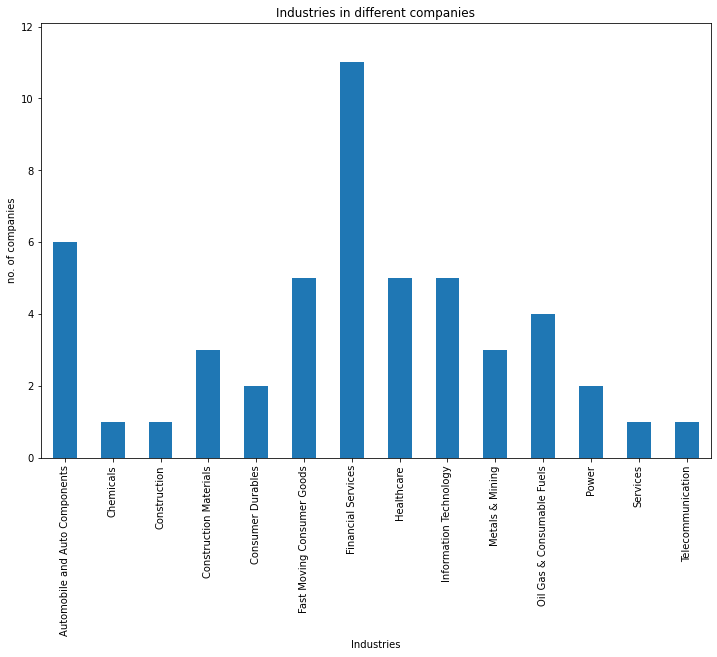

In [ ]:
# NIFTY 50 Sector Weightage Representation.
%matplotlib inline
ax = df_stocks_seg.plot(kind='bar', figsize=(12, 8), title='Industries in different companies',
             xlabel='Industries', ylabel='no. of companies', legend=False)

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

In [117]:
len(df_stocks)

50

In [ ]:
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.axis('equal')
# Industry = ['Automobile and Auto Components', 'Chemicals', 'Construction', 'Construction Materials',  'Consumer Durables', 
#             'Fast Moving Consumer Goods', 'Fast Moving Consumer Goods', 'Healthcare', 'Information Technology', 'Metals & Mining', 
#             'Oil Gas & Consumable Fuels', 'Power', 'Services']
# ax.pie(len(df_stocks.groupby(by = ['Industry']).count())/labels = Industry, autopct='%1.2f%%')
# plt.show()

ANALYSIS USING DEEP REINFORCEMENT LEARNING

In [8]:
df_stocks['Symbol'] = df_stocks['Symbol'].astype(str) + '.NS'

In [9]:
stocks_list = df_stocks['Symbol'].tolist()

In [118]:
start_date = '2014-01-01'
end_date = '2021-12-01'

df_NSE = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = stocks_list).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [119]:
""" Perform Feature Engineering """
df_NSE = FeatureEngineer(use_technical_indicator=True,
                                      tech_indicator_list = config.INDICATORS,
                                      use_turbulence=True,
                                      user_defined_feature = False).preprocess_data(df_NSE.copy())

Successfully added technical indicators
Successfully added turbulence index


In [12]:
df_NSE.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma',
       'close_60_sma', 'turbulence'],
      dtype='object')

In [120]:
df_stocks.head(50)

,Company Name,Industry,Symbol,Series,ISIN Code
0,Adani Ports and Special Economic Zone Ltd.,Services,ADANIPORTS,EQ,INE742F01042
1,Apollo Hospitals Enterprise Ltd.,Healthcare,APOLLOHOSP,EQ,INE437A01024
2,Asian Paints Ltd.,Consumer Durables,ASIANPAINT,EQ,INE021A01026
3,Axis Bank Ltd.,Financial Services,AXISBANK,EQ,INE238A01034
4,Bajaj Auto Ltd.,Automobile and Auto Components,BAJAJ-AUTO,EQ,INE917I01010
...,...,...,...,...,...
45,Tech Mahindra Ltd.,Information Technology,TECHM,EQ,INE669C01036
46,Titan Company Ltd.,Consumer Durables,TITAN,EQ,INE280A01028
47,UPL Ltd.,Chemicals,UPL,EQ,INE628A01036
48,UltraTech Cement Ltd.,Construction Materials,ULTRACEMCO,EQ,INE481G01011


In [ ]:
df_NSE.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2014-01-01,154.550003,157.750000,154.550003,150.426819,851727,ADANIPORTS.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,150.426819,150.426819,0.0
1,2014-01-01,940.250000,987.650024,940.250000,938.716614,335988,APOLLOHOSP.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,938.716614,938.716614,0.0
2,2014-01-01,494.399994,503.899994,492.000000,471.825500,1866326,ASIANPAINT.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,471.825500,471.825500,0.0
3,2014-01-01,260.299988,261.000000,257.640015,248.631042,2849425,AXISBANK.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,248.631042,248.631042,0.0
4,2014-01-01,1915.000000,1924.400024,1890.300049,1560.954224,90587,BAJAJ-AUTO.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,1560.954224,1560.954224,0.0


In [ ]:
tic_mean = df_NSE['close'].groupby(df_NSE['tic']).mean()

tic
ADANIPORTS.NS     359.620345
APOLLOHOSP.NS    1547.908140
ASIANPAINT.NS    1340.821982
AXISBANK.NS       547.310524
BAJAJ-AUTO.NS    2530.525629
                    ...     
TECHM.NS          599.818807
TITAN.NS          796.532041
ULTRACEMCO.NS    3904.574746
UPL.NS            432.897489
WIPRO.NS          255.302200
Name: close, Length: 48, dtype: float64

In [ ]:
def get_charts(stock_data):
    plt.rc('figure', figsize=(15, 10))
    
    fig, axes = plt.subplots(2, 1, 
                gridspec_kw={'height_ratios': [3, 1]})
    fig.tight_layout(pad=3)
    
    date = stock_data['Date']
    close = stock_data['Close']
    vol = stock_data['Volume']
    
    plot_price = axes[0]
    plot_price.plot(date, close, color='blue', 
    linewidth=2, label='Price')
    
    plot_vol = axes[1]
    plot_vol.bar(date, vol, width=15, color='darkgrey')

In [ ]:
for i, company in enumerate(stocks_list, 1):
  company_df = yf.download(company, start_date, end_date)
  company_df = company_df.reset_index()
  get_charts(company_df)

In [ ]:
company_df = company_df.reset_index()
company_df

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2014-01-01,211.500046,211.500046,206.662552,207.262558,192.681717,1181351
1,1,2014-01-02,207.262558,208.800049,204.806305,207.356308,192.768875,2441295
2,2,2014-01-03,205.125046,209.400055,204.862549,208.725052,194.041321,2953767
3,3,2014-01-06,209.962555,211.800049,208.125046,209.250046,194.529373,4948206
4,4,2014-01-07,209.250046,209.512558,204.375046,206.325058,191.810150,3286111
...,...,...,...,...,...,...,...,...
1944,1944,2021-11-24,644.299988,647.599976,633.099976,636.500000,630.218811,3992776
1945,1945,2021-11-25,637.000000,641.799988,633.000000,636.700012,630.416870,3330681
1946,1946,2021-11-26,632.000000,634.400024,619.650024,621.450012,615.317383,4138537
1947,1947,2021-11-29,616.549988,632.849976,603.950012,630.599976,624.377014,5188030


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

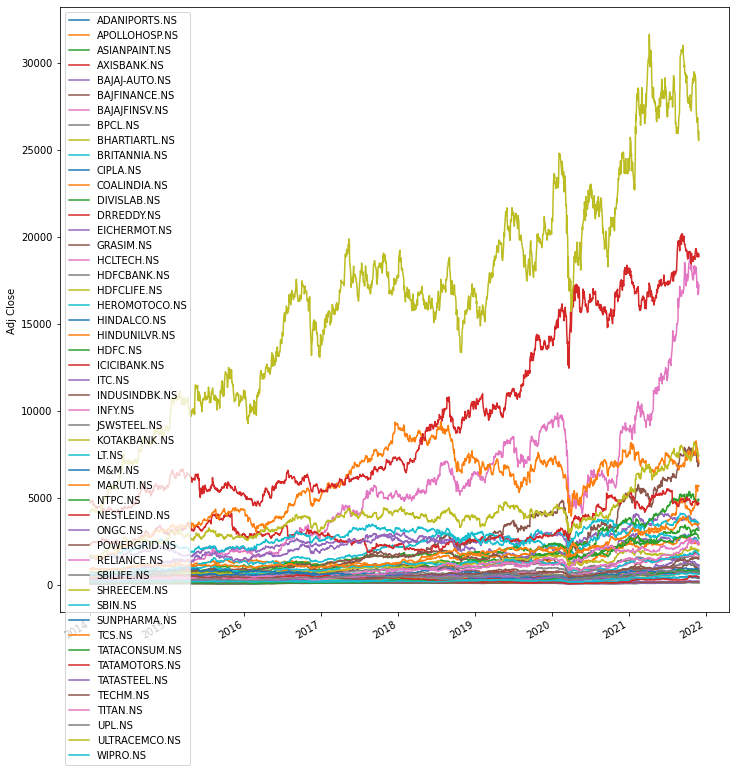

In [14]:
# To see a historical view of the closing price. 
#For historical view I’ll be using Adj. Closing price
%matplotlib inline
plt.figure(figsize=(12, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(stocks_list, 1):
  company_df = yf.download(company, start_date, end_date)
  company_df['Adj Close'].plot()
  plt.ylabel('Adj Close ')
  plt.xlabel(None)
  plt.legend(labels = stocks_list,loc='best')

In [ ]:
SBIN_df = yf.download('SBIN.NS', start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [16]:
#moving average for stocks over a 10, 20 and 50 day period of time.
ma_day = [10,20,50]
SBIN_df = yf.download("SBIN.NS", start_date, end_date)
for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    SBIN_df[column_name] = SBIN_df['Adj Close'].rolling(window=ma,center=False).mean()

SBIN_df.tail()  

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,MA for 10 days,MA for 20 days,MA for 50 days
Date,,,,,,,,,
2021-11-24,495.799988,500.000000,489.049988,493.149994,493.149994,13963769,502.154999,510.232504,482.358004
2021-11-25,490.000000,495.450012,486.299988,490.549988,490.549988,12894211,498.769995,509.132504,483.512003
2021-11-26,486.250000,487.899994,467.100006,470.500000,470.500000,26305817,494.859995,506.700003,484.262003
2021-11-29,470.000000,477.750000,454.299988,465.100006,465.100006,22407465,490.234995,504.887503,484.687003
2021-11-30,468.000000,477.250000,458.000000,460.549988,460.549988,23026652,485.634995,502.807503,484.624003


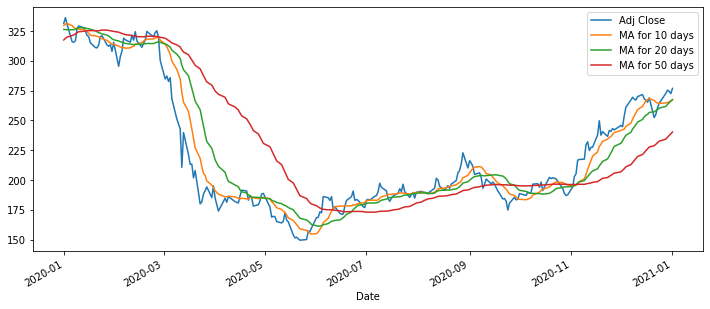

In [17]:
SBIN_df.truncate(before='2020-01-01', after='2021-01-01')[['Adj Close','MA for 10 days','MA for 20 days','MA for 50 days']].plot(subplots=False,figsize=(12,5))

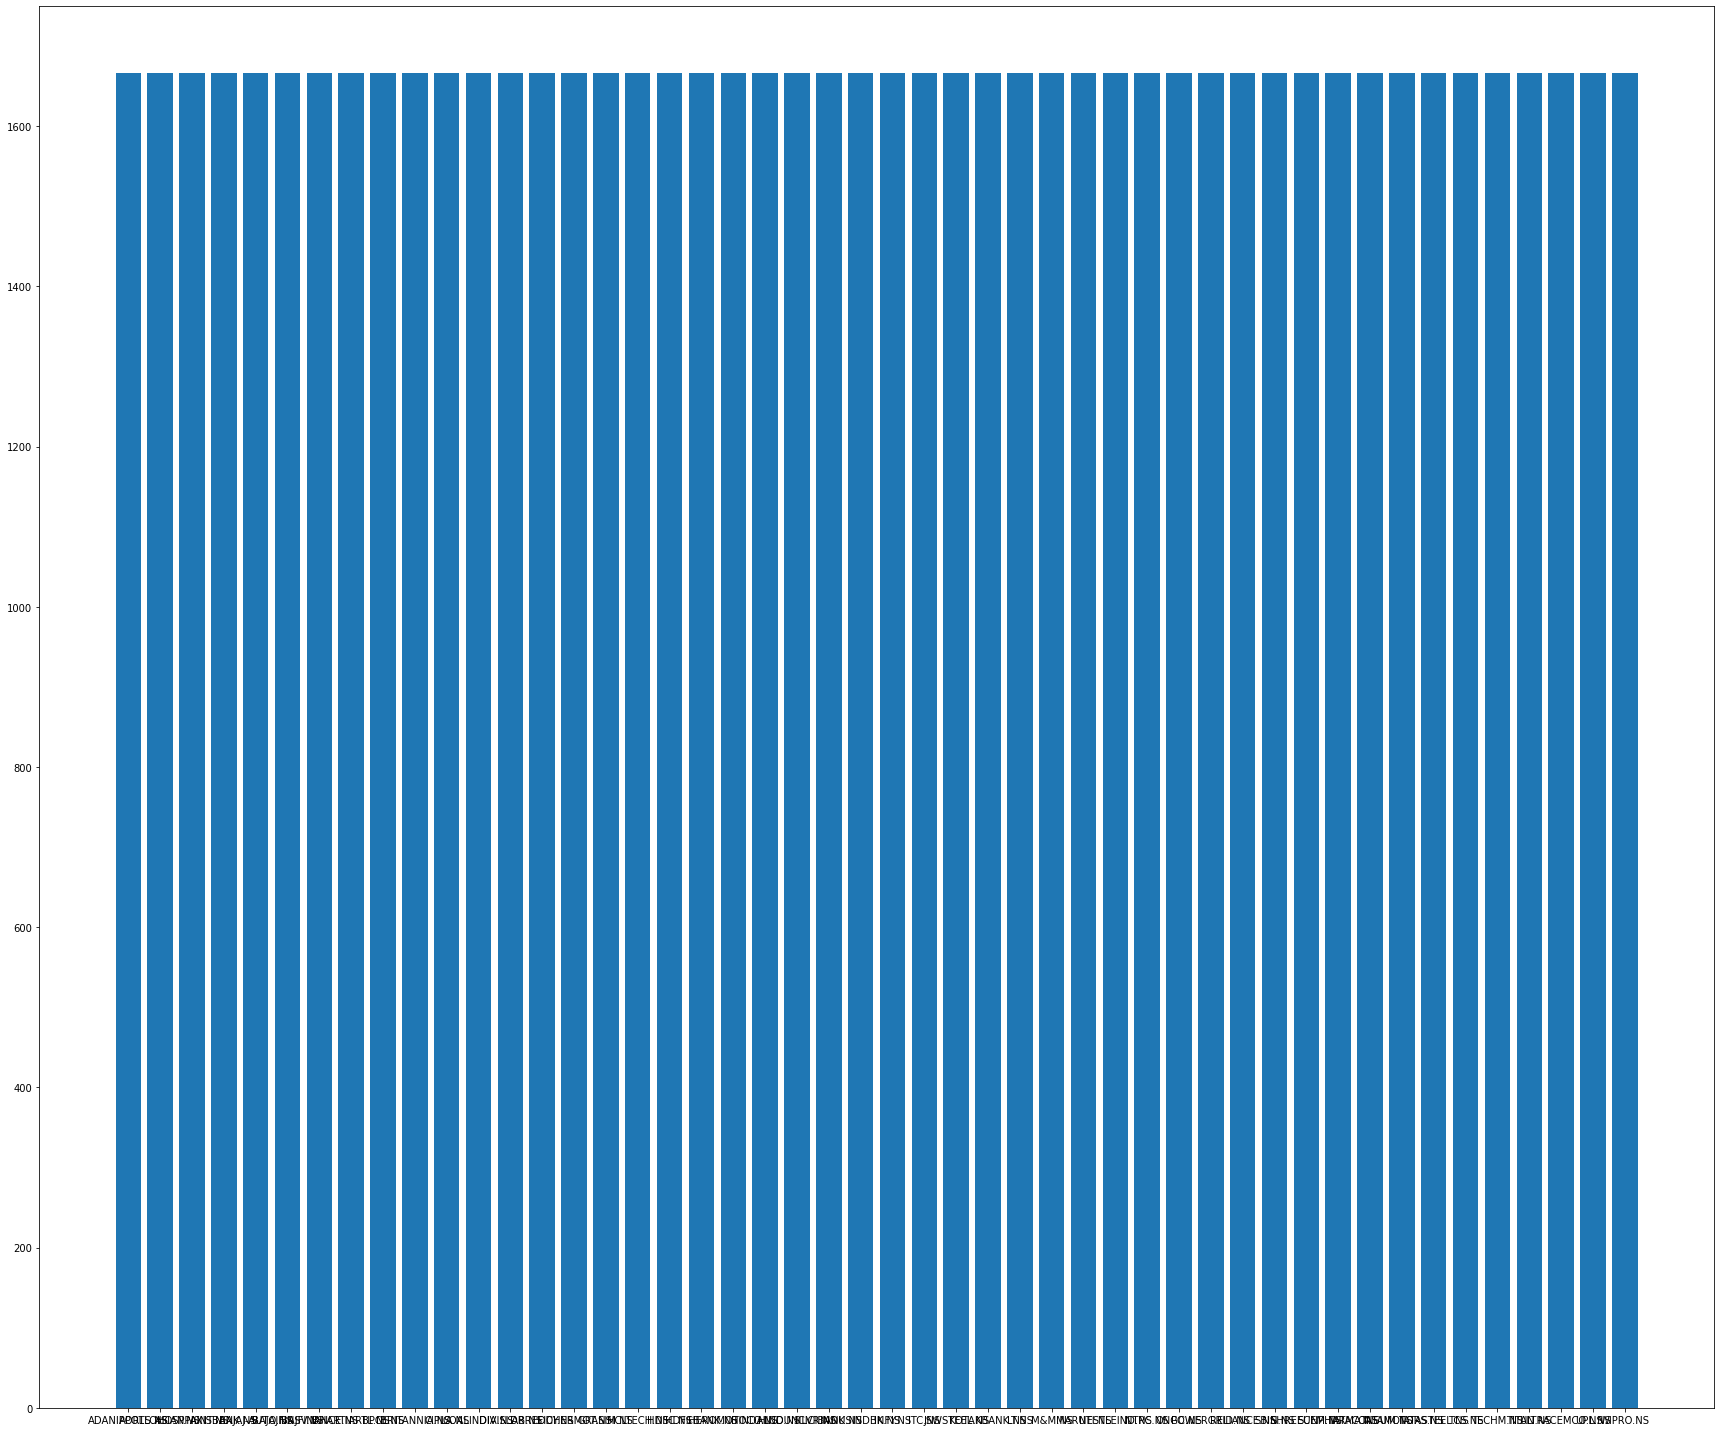

In [18]:
plt.figure(figsize=(24,20))
plt.bar(df_NSE['tic'], df_NSE['close'].mean())
plt.tight_layout()
plt.show()

Moving averages are used to identify significant support and resistance levels.
Traders watch for crossovers of longer-term moving averages by shorter-term moving averages as possible indicators of trend changes to enter long and short positions.
According to Stan Weinstein: The price must be above the short term MA in order to buy a stock.

In [19]:
# The daily return column can be created by using the percentage change over the adjusted closing price
SBIN_df['Daily Return'] = SBIN_df['Adj Close'].pct_change()

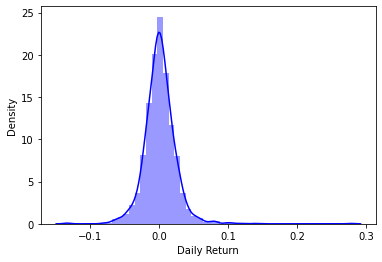

In [20]:
#univariant distribution
#Positive daily returns seem to be slightly less frequent than negative returns for SBIN.
sns.distplot(SBIN_df['Daily Return'].dropna(),bins=50,color='blue')

In [ ]:
df_NSE.head()

,date,open,high,low,close,volume,tic,day
0,2014-01-01,154.550003,157.750000,154.550003,150.426819,851727,ADANIPORTS.NS,2
1,2014-01-01,940.250000,987.650024,940.250000,938.716553,335988,APOLLOHOSP.NS,2
2,2014-01-01,494.399994,503.899994,492.000000,471.825470,1866326,ASIANPAINT.NS,2
3,2014-01-01,260.299988,261.000000,257.640015,248.631058,2849425,AXISBANK.NS,2
4,2014-01-01,1915.000000,1924.400024,1890.300049,1560.954224,90587,BAJAJ-AUTO.NS,2


In [21]:
df_pivot=df_NSE.fillna(0).pivot('date','tic','close').reset_index()
df_pivot.head()

tic,date,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,BPCL.NS,BRITANNIA.NS,CIPLA.NS,...,SBIN.NS,SHREECEM.NS,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,UPL.NS,WIPRO.NS
0,2014-01-01,150.426804,938.716614,471.825470,248.631042,1560.954224,755.766113,153.205627,296.388550,72.927994,415.513672,388.679077,...,166.483276,4201.690430,543.980530,143.735367,369.242859,338.857849,912.958618,382.834625,220.011139,1725.381714,121.793709,192.681686
1,2014-01-02,146.913971,901.189209,458.418915,244.802109,1546.829590,724.197083,153.098312,288.446838,70.891769,411.328827,379.536560,...,164.365753,4230.318359,545.406189,138.765106,366.682404,333.527130,918.767090,380.321625,215.769165,1688.177368,120.873131,192.768860
2,2014-01-03,144.267288,921.914001,462.148254,242.608612,1543.166138,725.141663,151.761673,289.017181,68.772011,414.789764,379.004425,...,162.201065,4260.346191,550.966309,140.018875,357.179291,328.196411,942.170654,384.384216,216.770096,1684.374268,122.806351,194.041321
3,2014-01-06,145.181625,915.861267,463.234009,241.723557,1537.263916,727.528015,151.366547,289.017181,68.876427,411.193146,378.859283,...,159.229889,4313.199219,559.092346,140.421875,361.364594,324.854828,949.548279,380.269165,217.151398,1681.546143,123.634895,194.529388
4,2014-01-07,140.465729,902.690308,462.573120,237.480942,1538.607178,726.881592,151.620163,291.079437,67.571159,408.908478,378.133728,...,156.706787,4250.336914,564.747498,140.153168,359.542755,314.034271,935.365662,377.798157,215.483200,1648.291626,123.818993,191.810181


In [22]:
#Combined Dataframe of all stocks
#Now, we can run the correlation. 
#Using the Pandas ‘corr’ function to compute the Pearson correlation coeffecient between each pair of equities.
corr_df = df_pivot.corr(method='pearson')
# reset symbol as index (rather than 0-X)
corr_df.head().reset_index()
# del corr_df.index.name
corr_df.head(10)

tic,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,BPCL.NS,BRITANNIA.NS,CIPLA.NS,COALINDIA.NS,...,SBIN.NS,SHREECEM.NS,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,UPL.NS,WIPRO.NS
tic,,,,,,,,,,,,,,,,,,,,,,,,,
ADANIPORTS.NS,1.000000,0.849268,0.872543,0.719683,0.885611,0.870748,0.862481,0.762556,0.722518,0.726075,0.796267,-0.377308,...,0.848604,0.831300,-0.041433,0.874715,-0.167879,0.889584,0.857000,0.848626,0.856302,0.935618,0.808541,0.890784
APOLLOHOSP.NS,0.849268,1.000000,0.877082,0.546537,0.773981,0.814401,0.826532,0.794595,0.556664,0.606605,0.806987,-0.465576,...,0.699759,0.722994,0.180720,0.899065,-0.097592,0.830339,0.849801,0.899606,0.805853,0.866390,0.638554,0.958995
ASIANPAINT.NS,0.872543,0.877082,1.000000,0.685731,0.920497,0.935504,0.969881,0.845679,0.786276,0.882123,0.742292,-0.655885,...,0.665921,0.922487,-0.206534,0.955645,-0.442281,0.791143,0.966023,0.894381,0.948786,0.928917,0.809901,0.890986
AXISBANK.NS,0.719683,0.546537,0.685731,1.000000,0.723416,0.779929,0.759257,0.455322,0.680443,0.686539,0.452250,-0.134135,...,0.806001,0.750146,-0.200409,0.553002,-0.317649,0.571431,0.693348,0.692507,0.745049,0.755640,0.828983,0.611857
BAJAJ-AUTO.NS,0.885611,0.773981,0.920497,0.723416,1.000000,0.891810,0.904060,0.782696,0.881193,0.849083,0.718702,-0.523093,...,0.716311,0.936825,-0.243842,0.874377,-0.322339,0.799491,0.870593,0.778345,0.875818,0.939758,0.873819,0.807468
BAJAJFINSV.NS,0.870748,0.814401,0.935504,0.779929,0.891810,1.000000,0.978771,0.781427,0.816443,0.865893,0.611442,-0.518557,...,0.782058,0.902871,-0.304872,0.882840,-0.433659,0.834205,0.918040,0.892387,0.967862,0.931031,0.875931,0.857258
BAJFINANCE.NS,0.862481,0.826532,0.969881,0.759257,0.904060,0.978771,1.000000,0.812455,0.793724,0.892251,0.636638,-0.624610,...,0.718399,0.915560,-0.312829,0.923376,-0.503408,0.787750,0.963931,0.903558,0.979126,0.917276,0.838449,0.867738
BHARTIARTL.NS,0.762556,0.794595,0.845679,0.455322,0.782696,0.781427,0.812455,1.000000,0.671894,0.717889,0.695175,-0.613981,...,0.550950,0.783536,-0.084055,0.898395,-0.304065,0.688934,0.813752,0.768882,0.815143,0.777095,0.595759,0.773772
BPCL.NS,0.722518,0.556664,0.786276,0.680443,0.881193,0.816443,0.793724,0.671894,1.000000,0.822453,0.489233,-0.450674,...,0.603912,0.913726,-0.418476,0.684985,-0.363751,0.619089,0.680321,0.559997,0.758249,0.827748,0.894087,0.557410


<Figure size 432x288 with 0 Axes>

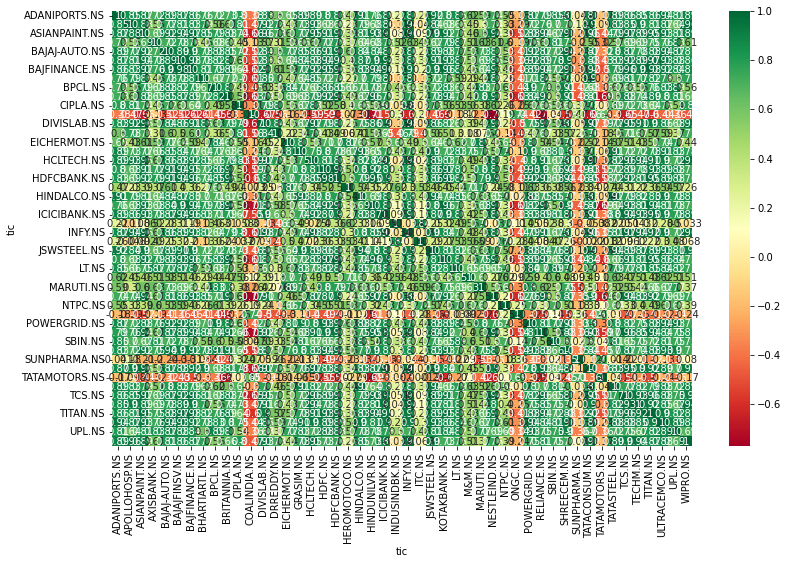

<Figure size 432x288 with 0 Axes>

In [23]:
#Correlation values between the stocks
#Now let’s use Seaborn library to plot a heatmap 
#and visualise the correlations in a better way
plt.figure(figsize=(13, 8))
sns.heatmap(corr_df, annot=True, cmap="RdYlGn")
plt.figure()

Text(0, 0.5, 'Price')

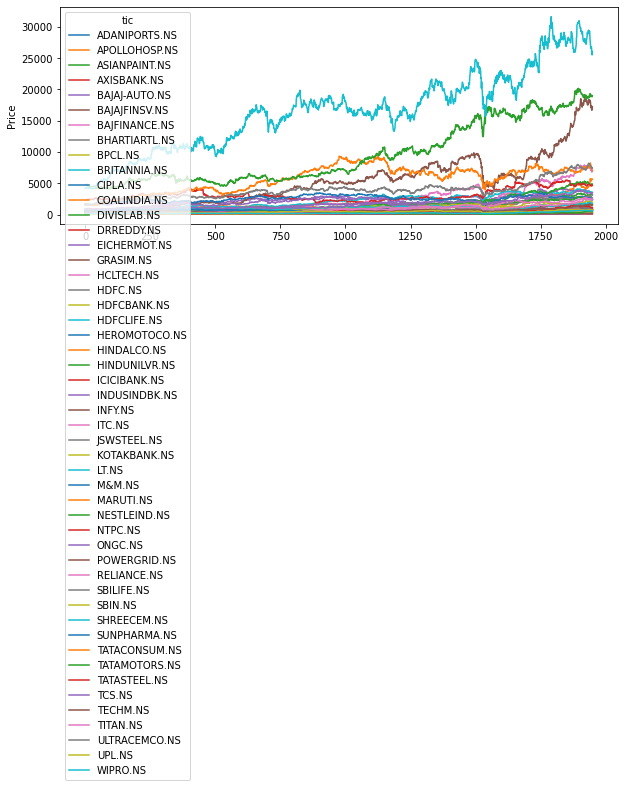

In [ ]:
# return of various stocks?
df_pivot.plot(figsize=(10,4))
plt.ylabel('Price')

In [24]:
#Daily Percentage Return
#Because I have 5stocks overlapping each other, it is a little hard to make any comparisons here.
#How much value do we put at risk by investing in a particular stock?
#A basic way to quantify risk is to compare the expected return (which can be the mean of the stock’s daily returns) with the standard deviation of the daily returns.
risk = corr_df.dropna()

In [25]:
#The 0.05 empirical quantile of daily returns is at 0.07627002139321137. 
#This means that with 95% confidence, the worst daily loss will not exceed 7.6% (of the investment).
risk['SBIN.NS'].quantile(0.05)

0.07627002139321137

Pivot Level, Resistence and Support for RELIANCE Stock

In [33]:
ticker = yf.Ticker("RELIANCE.NS")
df = ticker.history(interval="1d")

In [34]:
last_day = df.tail(1).copy()

In [35]:
#pivot levels, like Fibonacci, Woodie, Camarilla) and according to a strategy type (i.e. breakout or pullback).
last_day['Pivot'] = (last_day['High'] + last_day['Low'] + last_day['Close'])/3
last_day['R1'] = 2*last_day['Pivot'] - last_day['Low']
last_day['S1'] = 2*last_day['Pivot'] - last_day['High']
last_day['R2'] = last_day['Pivot'] + (last_day['High'] - last_day['Low'])
last_day['S2'] = last_day['Pivot'] - (last_day['High'] - last_day['Low'])
last_day['R3'] = last_day['Pivot'] + 2*(last_day['High'] - last_day['Low'])
last_day['S3'] = last_day['Pivot'] - 2*(last_day['High'] - last_day['Low'])
last_day

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Pivot,R1,S1,R2,S2,R3,S3
Date,,,,,,,,,,,,,,
2022-04-27,2755.850098,2828.0,2755.050049,2778.350098,8921630,0,0,2787.133382,2819.216715,2746.266764,2860.083333,2714.183431,2933.033285,2641.23348


In [29]:
start_date = '2014-01-01'
end_date = '2021-12-31'
df_TM = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = ["TATAMOTORS.NS"]).fetch_data()
df_SC = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = ["SHREECEM.NS"]).fetch_data()       
df_RIL = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = ["RELIANCE.NS"]).fetch_data()    
df_HDFCBANK = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = ["HDFCBANK.NS"]).fetch_data()
df_INFY = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = ["INFY.NS"]).fetch_data()       
df_BA = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = ["BHARTIARTL.NS"]).fetch_data()  
df_NSEI = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = ["^NSEI"]).fetch_data()
df_ASIANPAINT = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = ["ASIANPAINT.NS"]).fetch_data()                            
df_AXISBANK = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = ["AXISBANK.NS"]).fetch_data()  
df_ICICIBANK = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = ["ICICIBANK.NS"]).fetch_data()        
df_YESBANK = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = ["YESBANK.NS"]).fetch_data()  
df_SBIN = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = ["SBIN.NS"]).fetch_data() 
df_KOTAKBANK = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = ["KOTAKBANK.NS"]).fetch_data()                                                                                                                                   


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1971, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1971, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1971, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1971, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1971, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1971, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1959, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1971, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1971, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1971, 8)


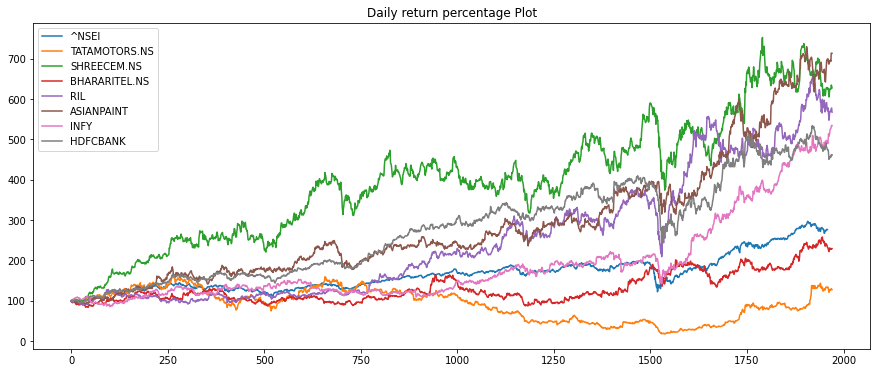

In [31]:
#Divide all the closing price to the first closing price in the period.
#Return From Start Price
#Daily return percentage Plot Diversified stocks.
ax = (df_NSEI['close'] / df_NSEI['close'].iloc[0] * 100).plot(figsize=(15, 6))
(df_TM['close'] / df_TM['close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
(df_SC['close'] / df_SC['close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
(df_BA['close'] / df_BA['close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
(df_RIL['close'] / df_RIL['close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
(df_ASIANPAINT['close'] / df_ASIANPAINT['close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
(df_INFY['close'] / df_INFY['close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
(df_HDFCBANK['close'] / df_HDFCBANK['close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
plt.title('Daily return percentage Plot')
plt.legend(['^NSEI','TATAMOTORS.NS', 'SHREECEM.NS', 'BHARARITEL.NS', 'RIL','ASIANPAINT','INFY','HDFCBANK'], loc='upper left')
plt.show()

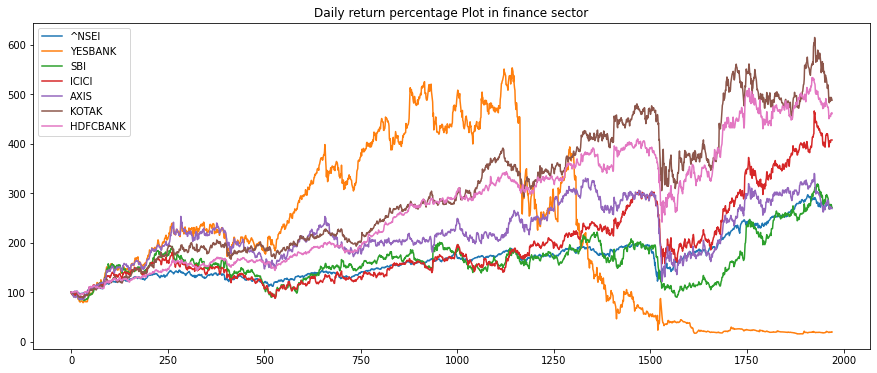

In [32]:
#Divide all the closing price to the first closing price in the period.
#Return From Start Price
#Daily return percentage Plot  Stocks in Banking sector.
ax = (df_NSEI['close'] / df_NSEI['close'].iloc[0] * 100).plot(figsize=(15, 6))
(df_YESBANK['close'] / df_YESBANK['close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
(df_SBIN['close'] / df_SBIN['close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
(df_ICICIBANK['close'] / df_ICICIBANK['close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
(df_AXISBANK['close'] / df_AXISBANK['close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
(df_KOTAKBANK['close'] / df_KOTAKBANK['close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
(df_HDFCBANK['close'] / df_HDFCBANK['close'].iloc[0] * 100).plot(ax=ax, figsize=(15,6))
plt.title('Daily return percentage Plot in finance sector')
plt.legend(['^NSEI','YESBANK', 'SBI', 'ICICI', 'AXIS','KOTAK','HDFCBANK'], loc='upper left')
plt.show()

Identify sudden change in the trend of stock prices , all automated and predicted with python

In [122]:
stock = input('Enter a stock symbol  ')

Enter a stock symbol  SBIN.NS


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1971, 8)

[180.6, 167.27, 154.0, 172.21, 212.49, 283.49, 276.15, 272.9, 257.74, 264.4, 279.98, 326.95, 318.3, 336.0, 313.15, 315.0, 294.9, 305.0, 271.2, 274.65, 291.8, 248.45, 257.15, 251.65, 253.0, 188.8, 189.85, 198.75, 202.55, 190.3, 218.5, 234.4, 235.15, 260.4, 271.6, 264.9, 264.9, 288.8, 269.35, 253.65, 282.8, 274.7, 280.5, 298.75, 296.9, 304.9, 315.3, 292.95, 295.9, 314.8, 282.1, 258.6, 351.3, 346.7, 323.85, 332.75, 280.0, 265.0, 274.8, 289.65, 265.75, 326.4, 312.5, 280.45, 300.0, 293.5, 292.45, 302.0, 307.5, 302.7, 339.65, 319.4, 364.0, 373.6, 373.8, 288.0, 316.0, 351.0, 339.5, 339.85, 337.95, 327.3, 331.9, 198.0, 195.9, 178.55, 197.5, 194.9, 202.5, 199.1, 207.3, 231.55, 205.95, 207.3, 253.0, 276.25, 310.9, 408.35, 427.7, 371.9, 369.95, 441.95, 436.5, 467.45, 471.9, 542.3, 500.45]
[1, 14, 30, 48, 79, 97, 107, 124, 160, 175, 205, 222, 245, 262, 275, 286, 314, 338, 360, 370, 391, 424, 440, 4

TypeError: ignored

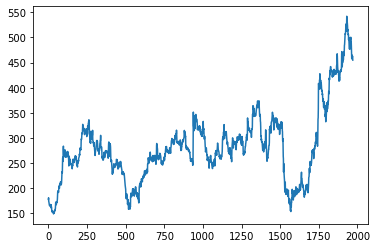

In [130]:
while stock != 'quit':
    start_date = '2014-01-01'
    end_date = '2021-12-31'
    df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = [stock]).fetch_data()             
    df['high'].plot(label='high')
    
    pivots =[]
    dates = []
    counter = 0
    lastPivot = 0
    Range = [0,0,0,0,0,0,0,0,0,0]
    daterange = [0,0,0,0,0,0,0,0,0,0]
    
    for i in df.index:
        currentMax = max(Range , default=0)
        value=round(df["high"][i],2)
        
        Range=Range[1:9]
        Range.append(value)
        daterange=daterange[1:9]
        daterange.append(i)
        
        if currentMax == max(Range , default=0):
            counter+=1
        else:
            counter = 0
        if counter ==  5:
            lastPivot=currentMax
            dateloc =Range.index(lastPivot)
            lastDate = daterange[dateloc]
            pivots.append(lastPivot)
            dates.append(lastDate)
    print()
    print(str(pivots))
    print(str(dates))
    import datetime as dt
    timeD = dt.timedelta(days=30)
    
    for index in range(len(pivots)):
        print(str(pivots[index])+" :" +str(dates[index]))        
        plt.plot_date([dates[index],dates[index]+ timeD],
            [pivots[index],pivots[index]] , linestyle='-' , linewidth=2, marker=',')
    
    plt.show()
    stock = input('Enter a stock symbol')

In [ ]:
# Define long and short window 
short_window = 50
long_window = 200
Reliance_df = yf.download('RELIANCE.NS', start_date, end_date)
Reliance_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-01,366.000000,366.024994,360.375000,361.274994,359.685150,785536
2014-01-02,361.299988,365.725006,351.500000,353.700012,352.143555,912278
2014-01-03,353.549988,358.149994,348.299988,356.274994,354.707184,1145134
2014-01-06,355.000000,358.500000,352.799988,357.049988,355.478790,893430
2014-01-07,356.000000,357.500000,350.000000,354.075012,352.516907,1287588
...,...,...,...,...,...,...
2021-11-24,1979.550049,2024.949951,1970.000000,2011.400024,2011.400024,1947483
2021-11-25,2020.000000,2048.000000,2013.050049,2035.099976,2035.099976,3164428
2021-11-26,2002.000000,2007.000000,1955.099976,1964.300049,1964.300049,2647553


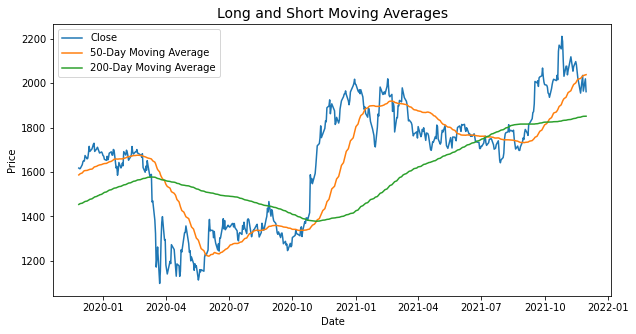

In [ ]:
# Define long and short window 
short_window = 50
long_window = 200

# Calculate moving averages
Reliance_df['short_mavg'] = Reliance_df['Close'].rolling(short_window).mean()
Reliance_df['long_mavg'] = Reliance_df['Close'].rolling(long_window).mean()

# Plot close price and moving averages
plot_data = Reliance_df[-500:]
plt.figure(figsize=(10, 5))
plt.title('Long and Short Moving Averages', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')

plt.plot(plot_data['Close'], label='Close')
plt.plot(plot_data['short_mavg'], label='50-Day Moving Average')
plt.plot(plot_data['long_mavg'], label='200-Day Moving Average')

plt.legend()

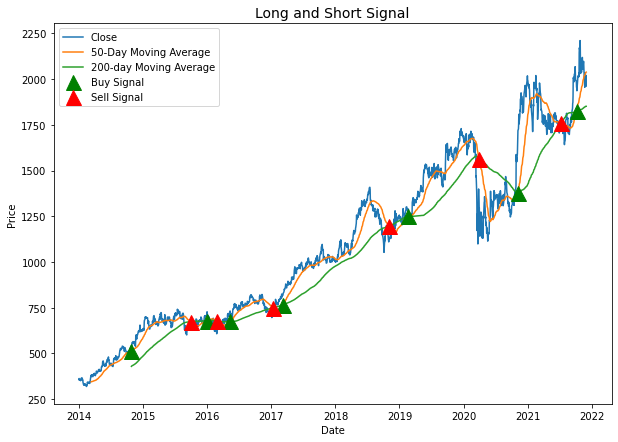

In [ ]:
# Take long positions
Reliance_df['long_positions'] = np.where(Reliance_df['short_mavg'] > Reliance_df['long_mavg'], 1, 0)

# Take short positions
Reliance_df['short_positions'] = np.where(Reliance_df['short_mavg'] < Reliance_df['long_mavg'], -1, 0)

Reliance_df['positions'] = Reliance_df['long_positions'] + Reliance_df['short_positions'] 

# Plot close price and moving averages
plot_data = Reliance_df[-3000:]
plt.figure(figsize=(10, 7))
plt.title('Long and Short Signal', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')

plt.plot(plot_data['Close'], label='Close')
plt.plot(plot_data['short_mavg'], label='50-Day Moving Average')
plt.plot(plot_data['long_mavg'], label='200-day Moving Average')


plt.plot(plot_data[(plot_data['long_positions'] == 1) &
                       (plot_data['long_positions'].shift(1) == 0)]['short_mavg'],
         '^', ms=15, label='Buy Signal', color='green')


plt.plot(plot_data[(plot_data['short_positions'] == -1) &
                       (plot_data['short_positions'].shift(1) == 0)]['short_mavg'],
         '^', ms=15, label='Sell Signal', color='red')

plt.legend()
plt.show()

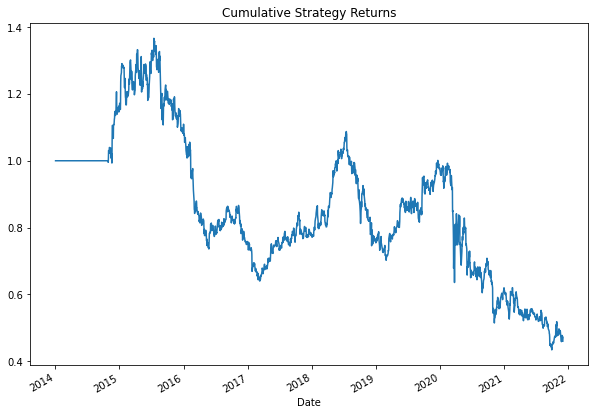

In [ ]:
# Calculate daily returns
Reliance_df['returns'] = Reliance_df['Close'].pct_change()

# Calculate strategy returns
Reliance_df['strategy_returns'] = Reliance_df['returns'] * Reliance_df['positions'].shift(1)

# Plot cumulative returns
cumulative_returns = (Reliance_df['strategy_returns'] + 1).cumprod()
cumulative_returns.plot(figsize=(10, 7))
plt.title('Cumulative Strategy Returns')
plt.show()

In [ ]:
# Total number of trading days
days = len(cumulative_returns)

# Calculate compounded annual growth rate
# We will use 252 instead oof 365, as number of trading days in a year is 252
annualised_returns = (cumulative_returns.iloc[-1]**(252/days)-1)*100

# Calculate annualised volatility
annualised_volatility = np.std(Reliance_df.strategy_returns)*(252**0.5)*100

# Assume an average annual risk-free rate is 1%
risk_free_rate = 0.01/252

sharpe_ratio = np.sqrt(252)*(np.mean(Reliance_df.strategy_returns) -
                       (risk_free_rate))/np.std(Reliance_df.strategy_returns)

# Calculate the running maximum
running_max = np.maximum.accumulate(cumulative_returns.dropna())

# Ensure the value never drops below 1
running_max[running_max < 1] = 1

# Calculate the percentage drawdown
drawdown = (cumulative_returns)/running_max - 1
max_dd = drawdown.min()*100

print('The sharpe ratio of strategy is %.2f' % sharpe_ratio + '%')
print('The annualised returns of strategy is %.2f' % annualised_returns + '%')

The sharpe ratio of strategy is -0.28%
The annualised returns of strategy is -9.55%


In [ ]:
#Therefore we can say that the strategy is sub-optimal, and there is a lot of scope for improvement.

#There are lots of performance and risk indicators that can be used for evaluation purposes.

#But among them which one should you choose? So the next question is:
#the Sharpe ratio as it provides information about the returns per unit risk. So, it is using both factors, risk and returns.

In [66]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_turbulence=False,
                    user_defined_feature = False)

df_NSE = fe.preprocess_data(df_NSE)
df_NSE.head()

Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd_x,boll_ub_x,boll_lb_x,rsi_30_x,...,cci_30_y,dx_30_y,close_30_sma_y,close_60_sma_y,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2014-01-01,154.550003,157.750000,154.550003,150.426804,851727,ADANIPORTS.NS,2,0.0,153.638283,143.702492,0.0,...,-66.666667,100.0,150.426804,150.426804,0.0,153.638283,143.702492,0.0,-66.666667,100.0,150.426804,150.426804
1949,2014-01-01,940.250000,987.650024,940.250000,938.716614,335988,APOLLOHOSP.NS,2,0.0,153.638283,143.702492,0.0,...,-66.666667,100.0,938.716614,938.716614,0.0,153.638283,143.702492,0.0,-66.666667,100.0,938.716614,938.716614
3898,2014-01-01,494.399994,503.899994,492.000000,471.825470,1866326,ASIANPAINT.NS,2,0.0,153.638283,143.702492,0.0,...,-66.666667,100.0,471.825470,471.825470,0.0,153.638283,143.702492,0.0,-66.666667,100.0,471.825470,471.825470
5847,2014-01-01,260.299988,261.000000,257.640015,248.631042,2849425,AXISBANK.NS,2,0.0,153.638283,143.702492,0.0,...,-66.666667,100.0,248.631042,248.631042,0.0,153.638283,143.702492,0.0,-66.666667,100.0,248.631042,248.631042
7796,2014-01-01,1915.000000,1924.400024,1890.300049,1560.954224,90587,BAJAJ-AUTO.NS,2,0.0,153.638283,143.702492,0.0,...,-66.666667,100.0,1560.954224,1560.954224,0.0,153.638283,143.702492,0.0,-66.666667,100.0,1560.954224,1560.954224


In [131]:
# Train and trade data
train = data_split(df_NSE, start = start_date, end = '2020-01-01')
trade = data_split(df_NSE, start = '2020-01-01', end = end_date)
# Check the length of the two datasets
print(len(train))
print(len(trade))

70704
22848


In [132]:
# Compute State Space and Action Space
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 48, State Space: 481


In [69]:
# New
buy_cost_list = [0.001] * stock_dimension
sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

# Initialize an environment class
env_kwargs = {
    "hmax": 100,                                                # max number of share purchases allowed per asset
    "initial_amount": 1000000,                                  # amount of cash initially available
    "buy_cost_pct": buy_cost_list,                              # cost for buying shares
    "sell_cost_pct": sell_cost_list,                            # cost for selling shares
    "state_space": state_space,                                 # contains all of the environment’s data to be observed by the agent
    "stock_dim": stock_dimension,
    "num_stock_shares": num_stock_shares, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension,                            # contain all of the actions possible for an agent to take in the environment
    "reward_scaling": 1e-4 }                                    # scaling value to multiply reward by at each step

e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [70]:
# Train SAC Model
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 200,
    "ent_coef": "auto_0.1"
}
model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=30000)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 200, 'ent_coef': 'auto_0.1'}
Using cpu device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 19        |
|    time_elapsed    | 308       |
|    total_timesteps | 5892      |
| train/             |           |
|    actor_loss      | 1.62e+03  |
|    critic_loss     | 293       |
|    ent_coef        | 0.163     |
|    ent_coef_loss   | 357       |
|    learning_rate   | 0.0001    |
|    n_updates       | 5691      |
|    reward          | 1.4060335 |
----------------------------------
------------------------------------
| time/              |             |
|    episodes        | 8           |
|    fps             | 18          |
|    time_elapsed    | 633         |
|    total_timesteps | 11784       |
| train/             |             |
|    actor_loss      | 1.85e+03    |
|    critic_loss     | 102         |
|    ent_

In [71]:
""" Create trading env and make prediction and get the account value change """
# YOUR CODE HERE
# Create trading env
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

# Make prediction and get the account value change
df_account_value, df_actions = DRLAgent.DRL_prediction(model = trained_sac, environment = e_trade_gym)

hit end!


In [73]:
df_actions

,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,BPCL.NS,BRITANNIA.NS,CIPLA.NS,COALINDIA.NS,...,SBIN.NS,SHREECEM.NS,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,UPL.NS,WIPRO.NS
date,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0,0,0,0,0,0,0,100,...,0,0,0,0,0,0,0,0,0,0,0,100
2020-01-02,0,0,0,0,0,0,0,0,0,0,0,-67,...,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,0,-33,...,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-06,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-07,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-23,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
2021-11-24,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
2021-11-25,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
""" BackTest Stats """
perf_stats_all = backtest_stats(account_value = df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

Annual return          0.130335
Cumulative returns     0.260382
Annual volatility      0.280957
Sharpe ratio           0.578660
Calmar ratio           0.377932
Stability              0.710209
Max drawdown          -0.344863
Omega ratio            1.123731
Sortino ratio          0.796911
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.931629
Daily value at risk   -0.034752
dtype: float64


In [74]:
# Baseline stats
baseline_df = get_baseline(ticker = '^NSEI',
                            start = start_date,
                            end = end_date)
stats = backtest_stats(baseline_df, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1959, 8)
Annual return          0.139794
Cumulative returns     1.765397
Annual volatility      0.171084
Sharpe ratio           0.851673
Calmar ratio           0.363670
Stability              0.831695
Max drawdown          -0.384399
Omega ratio            1.173746
Sortino ratio          1.173925
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.007724
Daily value at risk   -0.020976
dtype: float64


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1959, 8)


Start date,2020-01-01
End date,2021-11-30
Total months,22
,Backtest
Annual return,13.033%
Cumulative returns,26.038%
Annual volatility,28.096%
Sharpe ratio,0.58
Calmar ratio,0.38
Stability,0.71
Max drawdown,-34.486%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.49,2020-01-17,2020-04-03,2020-08-18,153
1,13.23,2021-02-16,2021-04-19,2021-11-08,190
2,11.77,2020-08-28,2020-09-24,2020-10-27,43
3,9.79,2021-01-14,2021-01-29,2021-02-15,23
4,8.91,2021-11-08,2021-11-29,NaT,NaN


Stress Events,mean,min,max
New Normal,0.06%,-13.34%,10.09%


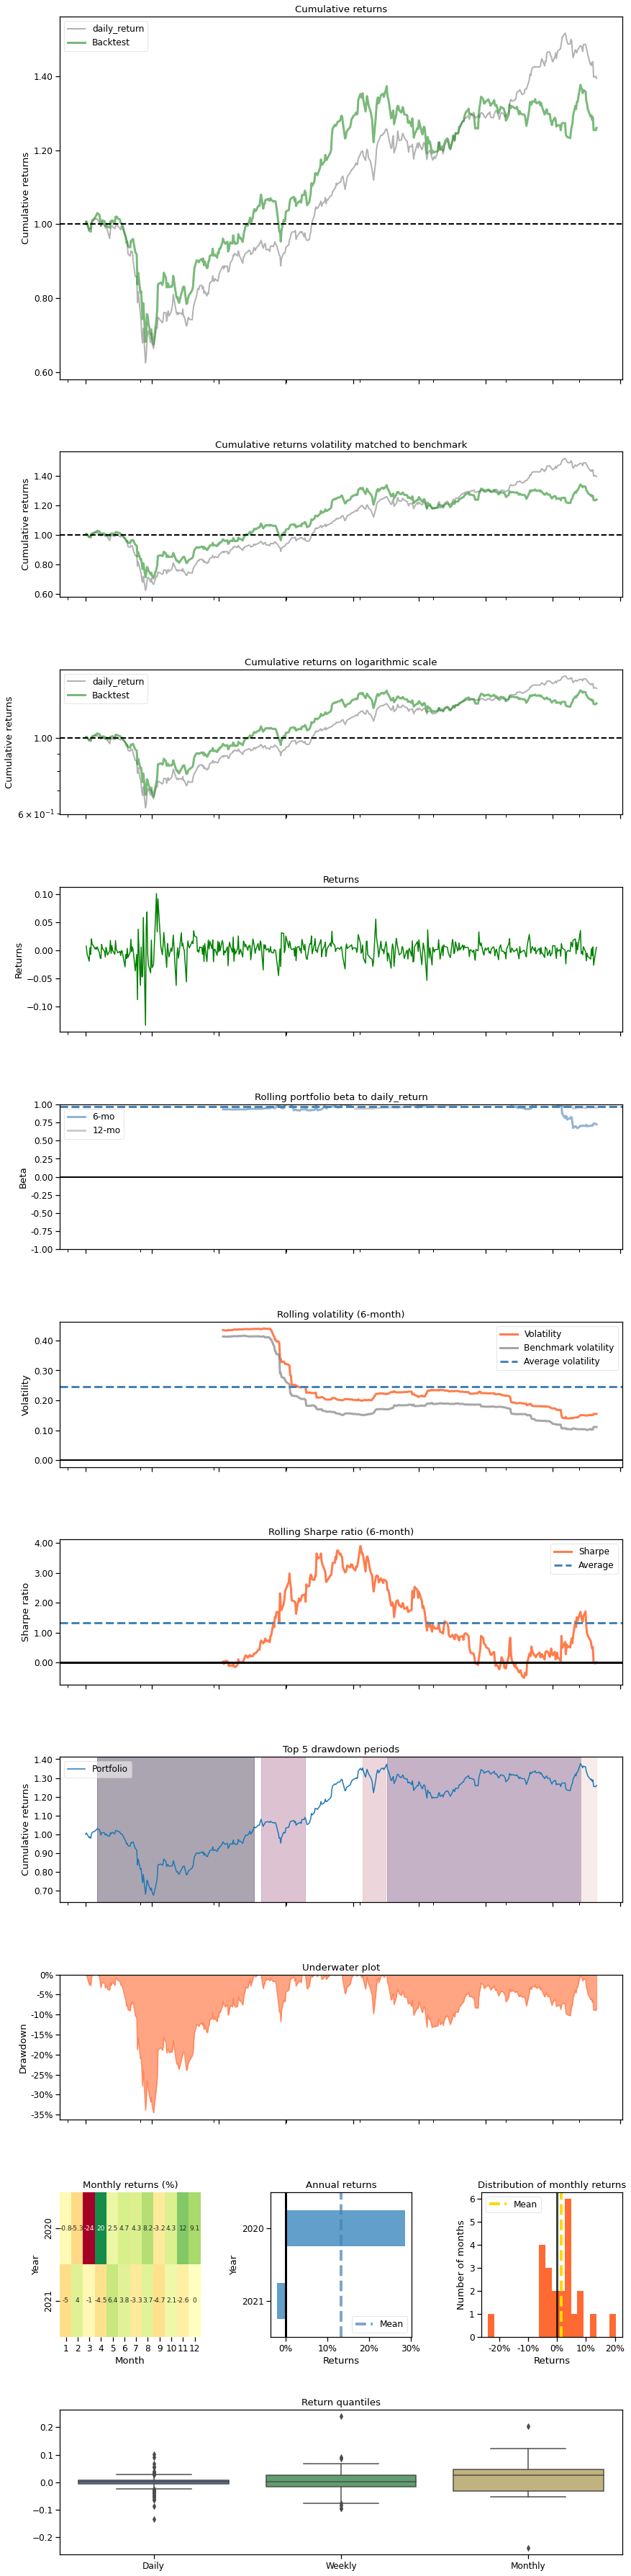

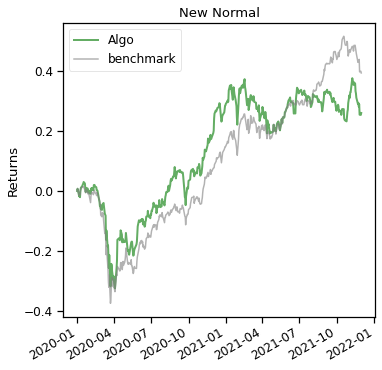

In [75]:
""" BackTest Plot """
# YOUR CODE HERE
%matplotlib inline
backtest_plot(account_value = df_account_value,     # pass the account value memory into the backtest functions
              baseline_ticker = '^NSEI',             # select a baseline ticker Dow Jones Index: ^DJI, S&P 500: ^GSPC, NASDAQ 100: ^NDX
              baseline_start = start_date, 
              baseline_end =  end_date)

### FinRL Hyperparameter tuning using Optuna

In [76]:
#Instantiate the trading environment using turbulence_threshold = None
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = None, **env_kwargs)

In [77]:
#Main method
# Calculates Trade Performance for Objective
# Called from objective method
# Returns selected trade perf metric(s)
# Requires actions and associated prices

def calc_trade_perf_metric(df_actions, 
                           df_prices_trade,
                           tp_metric,
                           dbg=False):
  
    df_actions_p, df_prices_p, tics = prep_data(df_actions.copy(),
                                                df_prices_trade.copy())
    # actions predicted by trained model on trade data
    df_actions_p.to_csv('df_actions.csv') 

    
    # Confirms that actions, prices and tics are consistent
    df_actions_s, df_prices_s, tics_prtfl = \
        sync_tickers(df_actions_p.copy(),df_prices_p.copy(),tics)
    
    # copy to ensure that tics from portfolio remains unchanged
    tics = tics_prtfl.copy()
    
    # Analysis is performed on each portfolio ticker
    perf_data= collect_performance_data(df_actions_s, df_prices_s, tics)
    # profit/loss for each ticker
    pnl_all = calc_pnl_all(perf_data, tics)
    # values for trade performance metrics
    perf_results = calc_trade_perf(pnl_all)
    df = pd.DataFrame.from_dict(perf_results, orient='index')
    
    # calculate and return trade metric value as objective
    m = calc_trade_metric(df,tp_metric)
    print(f'Ratio Avg Win/Avg Loss: {m}')
    k = str(len(tpm_hist)+1)
    # save metric value
    tpm_hist[k] = m
    return m

In [78]:
# Supporting methods
def calc_trade_metric(df,metric='avgwl'):
    '''# trades', '# wins', '# losses', 'wins total value', 'wins avg value',
       'losses total value', 'losses avg value'''
    # For this tutorial, the only metric available is the ratio of 
    #  average values of winning to losing trades. Others are in development.
    
    # some test cases produce no losing trades.
    # The code below assigns a value as a multiple of the highest value during
    # previous hp optimization runs. If the first run experiences no losses,
    # a fixed value is assigned for the ratio
    tpm_mult = 1.0
    avgwl_no_losses = 25
    if metric == 'avgwl':
        if sum(df['# losses']) == 0:
          try:
            return max(tpm_hist.values())*tpm_mult
          except ValueError:
            return avgwl_no_losses
        avg_w = sum(df['wins total value'])/sum(df['# wins'])
        avg_l = sum(df['losses total value'])/sum(df['# losses'])
        m = abs(avg_w/avg_l)

    return m


def prep_data(df_actions,
              df_prices_trade):
    
    df=df_prices_trade[['date','close','tic']]
    df['Date'] = pd.to_datetime(df['date'])
    df = df.set_index('Date')
    # set indices on both df to datetime
    idx = pd.to_datetime(df_actions.index, infer_datetime_format=True)
    df_actions.index=idx
    tics = np.unique(df.tic)
    n_tics = len(tics)
    print(f'Number of tickers: {n_tics}')
    print(f'Tickers: {tics}')
    dategr = df.groupby('tic')
    p_d={t:dategr.get_group(t).loc[:,'close'] for t in tics}
    df_prices = pd.DataFrame.from_dict(p_d)
    df_prices.index = df_prices.index.normalize()
    return df_actions, df_prices, tics


# prepares for integrating action and price files
def link_prices_actions(df_a,
                        df_p):
    cols_a = [t + '_a' for t in df_a.columns]
    df_a.columns = cols_a
    cols_p = [t + '_p' for t in df_p.columns]
    df_p.columns = cols_p
    return df_a, df_p


def sync_tickers(df_actions,df_tickers_p,tickers):
    # Some DOW30 components may not be included in portfolio
    # passed tickers includes all DOW30 components
    # actions and ticker files may have different length indices
    if len(df_actions) != len(df_tickers_p):
      msng_dates = set(df_actions.index)^set(df_tickers_p.index)
      try:
        #assumption is prices has one additional timestamp (row)
        df_tickers_p.drop(msng_dates,inplace=True)
      except:
        df_actions.drop(msng_dates,inplace=True)
    df_actions, df_tickers_p = link_prices_actions(df_actions,df_tickers_p)
    # identify any DOW components not in portfolio
    t_not_in_a = [t for t in tickers if t + '_a' not in list(df_actions.columns)]
  
    # remove t_not_in_a from df_tickers_p
    drop_cols = [t + '_p' for t in t_not_in_a]
    df_tickers_p.drop(columns=drop_cols,inplace=True)
    
    # Tickers in portfolio
    tickers_prtfl = [c.split('_')[0] for c in df_actions.columns]
    return df_actions,df_tickers_p, tickers_prtfl

def collect_performance_data(dfa,dfp,tics, dbg=False):
    
    perf_data = {}
    # In current version, files columns include secondary identifier
    for t in tics:
        # actions: purchase/sale of DOW equities
        acts = dfa['_'.join([t,'a'])].values
        # ticker prices
        prices = dfp['_'.join([t,'p'])].values
        # market value of purchases/sales
        tvals_init = np.multiply(acts,prices)
        d={'actions':acts, 'prices':prices,'init_values':tvals_init}
        perf_data[t]=d

    return perf_data


def calc_pnl_all(perf_dict, tics_all):
    # calculate profit/loss for each ticker
    print(f'Calculating profit/loss for each ticker')
    pnl_all = {}
    for tic in tics_all:
        pnl_t = []
        tic_data = perf_dict[tic]
        init_values = tic_data['init_values']
        acts = tic_data['actions']
        prices = tic_data['prices']
        cs = np.cumsum(acts)
        args_s = [i + 1 for i in range(len(cs) - 1) if cs[i + 1] < cs[i]]
        # tic actions with no sales
        if not args_s:
            pnl = complete_calc_buyonly(acts, prices, init_values)
            pnl_all[tic] = pnl
            continue
        # copy acts: acts_rev will be revised based on closing/reducing init positions
        pnl_all = execute_position_sales(tic,acts,prices,args_s,pnl_all)

    return pnl_all


def complete_calc_buyonly(actions, prices, init_values):
    # calculate final pnl for each ticker assuming no sales
    fnl_price = prices[-1]
    final_values = np.multiply(fnl_price, actions)
    pnl = np.subtract(final_values, init_values)
    return pnl


def execute_position_sales(tic,acts,prices,args_s,pnl_all):
  # calculate final pnl for each ticker with sales
    pnl_t = []
    acts_rev = acts.copy()
    # location of sales transactions
    for s in args_s:  # s is scaler
        # price_s = [prices[s]]
        act_s = [acts_rev[s]]
        args_b = [i for i in range(s) if acts_rev[i] > 0]
        prcs_init_trades = prices[args_b]
        acts_init_trades = acts_rev[args_b]
  
        # update actions for sales
        # reduce/eliminate init values through trades
        # always start with earliest purchase that has not been closed through sale
        # selectors for purchase and sales trades
        # find earliest remaining purchase
        arg_sel = min(args_b)
        # sel_s = len(acts_trades) - 1

        # closing part/all of earliest init trade not yet closed
        # sales actions are negative
        # in this test case, abs_val of init and sales share counts are same
        # zero-out sales actions
        # market value of sale
        # max number of shares to be closed: may be less than # originally purchased
        acts_shares = min(abs(act_s.pop()), acts_rev[arg_sel])

        # mv of shares when purchased
        mv_p = abs(acts_shares * prices[arg_sel])
        # mv of sold shares
        mv_s = abs(acts_shares * prices[s])

        # calc pnl
        pnl = mv_s - mv_p
        # reduce init share count
        # close all/part of init purchase
        acts_rev[arg_sel] -= acts_shares
        acts_rev[s] += acts_shares
        # calculate pnl for trade
        # value of associated purchase
        
        # find earliest non-zero positive act in acts_revs
        pnl_t.append(pnl)
    
    pnl_op = calc_pnl_for_open_positions(acts_rev, prices)
    #pnl_op is list
    # add pnl_op results (if any) to pnl_t (both lists)
    pnl_t.extend(pnl_op)
    #print(f'Total pnl for {tic}: {np.sum(pnl_t)}')
    pnl_all[tic] = np.array(pnl_t)
    return pnl_all


def calc_pnl_for_open_positions(acts,prices):
    # identify any positive share values after accounting for sales
    pnl = []
    fp = prices[-1] # last price
    open_pos_arg = np.argwhere(acts>0)
    if len(open_pos_arg)==0:return pnl # no open positions

    mkt_vals_open = np.multiply(acts[open_pos_arg], prices[open_pos_arg])
    # mkt val at end of testing period
    # treat as trades for purposes of calculating pnl at end of testing period
    mkt_vals_final = np.multiply(fp, acts[open_pos_arg])
    pnl_a = np.subtract(mkt_vals_final, mkt_vals_open)
    #convert to list
    pnl = [i[0] for i in pnl_a.tolist()]
    #print(f'Market value of open positions at end of testing {pnl}')
    return pnl


def calc_trade_perf(pnl_d):
    # calculate trade performance metrics
    perf_results = {}
    for t,pnl in pnl_d.items():
        wins = pnl[pnl>0]  # total val
        losses = pnl[pnl<0]
        n_wins = len(wins)
        n_losses = len(losses)
        n_trades = n_wins + n_losses
        wins_val = np.sum(wins)
        losses_val = np.sum(losses)
        wins_avg = 0 if n_wins==0 else np.mean(wins)
        #print(f'{t} n_wins: {n_wins} n_losses: {n_losses}')
        losses_avg = 0 if n_losses==0 else np.mean(losses)
        d = {'# trades':n_trades,'# wins':n_wins,'# losses':n_losses,
             'wins total value':wins_val, 'wins avg value':wins_avg,
             'losses total value':losses_val, 'losses avg value':losses_avg,}
        perf_results[t] = d
    return perf_results

In [80]:
% pip install optuna

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 7.4 MB/s 
     |████████████████████████████████| 210 kB 40.9 MB/s 
     |████████████████████████████████| 78 kB 4.0 MB/s 
     |████████████████████████████████| 146 kB 52.9 MB/s 
     |████████████████████████████████| 49 kB 4.6 MB/s 
     |████████████████████████████████| 113 kB 50.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=90df0a3318009effd2e268318248045e625c5f991e2813f5ed7d93fa53aefad1
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [81]:
import optuna

In [82]:
def sample_sac_params(trial:optuna.Trial):
  # Size of the replay buffer
  buffer_size = trial.suggest_categorical("buffer_size", [int(1e4), int(1e5), int(1e6)])
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1)
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512])
  learning_starts = trial.suggest_categorical("learning_starts", [200, 400, 800, 1600, 2400])
  
  return {"buffer_size": buffer_size,
          "learning_rate":learning_rate,
          "batch_size":batch_size,
          "learning_starts": learning_starts,
          "ent_coef": "auto_0.1"}

In [83]:
def sample_sac_params_all(trial:optuna.Trial,
                           # fixed values from previous study
                           learning_rate=0.0001,
                           batch_size=128,
                           buffer_size=100000):

    gamma = trial.suggest_categorical("gamma", [0.94, 0.96, 0.98])
    # Polyak coeff
    tau = trial.suggest_categorical("tau", [0.08, 0.1, 0.12])

    train_freq = trial.suggest_categorical("train_freq", [512,768,1024])
    gradient_steps = train_freq
    
    noise_type = trial.suggest_categorical("noise_type", ["ornstein-uhlenbeck", "normal", None])
    noise_std = trial.suggest_categorical("noise_std", [.1,.2,.3] )

    # NOTE: Add "verybig" to net_arch when tuning HER (see TD3)
    net_arch = trial.suggest_categorical("net_arch", ["small", "big"])
    # activation_fn = trial.suggest_categorical('activation_fn', [nn.Tanh, nn.ReLU, nn.ELU, nn.LeakyReLU])

    net_arch = {
        "small": [64, 64],
        "medium": [256, 256],
        "big": [512, 512],
    }[net_arch]
  
    hyperparams = {
        "batch_size": batch_size,
        "buffer_size": buffer_size,
        "gamma": gamma,
        "gradient_steps": gradient_steps,
        "learning_rate": learning_rate,
        "tau": tau,
        "train_freq": train_freq,
        #"noise_std": noise_std,
        #"noise_type": noise_type,
        
        "policy_kwargs": dict(net_arch=net_arch)
    }
    return hyperparams

In [84]:
class LoggingCallback:
    def __init__(self,threshold,trial_number,patience):
      '''
      threshold:int tolerance for increase in objective
      trial_number: int Prune after minimum number of trials
      patience: int patience for the threshold
      '''
      self.threshold = threshold
      self.trial_number  = trial_number
      self.patience = patience
      print(f'Callback threshold {self.threshold}, \
            trial_number {self.trial_number}, \
            patience {self.patience}')
      self.cb_list = [] #Trials list for which threshold is reached
    def __call__(self,study:optuna.study, frozen_trial:optuna.Trial):
      #Setting the best value in the current trial
      study.set_user_attr("previous_best_value", study.best_value)
      
      #Checking if the minimum number of trials have pass
      if frozen_trial.number >self.trial_number:
          previous_best_value = study.user_attrs.get("previous_best_value",None)
          #Checking if the previous and current objective values have the same sign
          if previous_best_value * study.best_value >=0:
              #Checking for the threshold condition
              if abs(previous_best_value-study.best_value) < self.threshold: 
                  self.cb_list.append(frozen_trial.number)
                  #If threshold is achieved for the patience amount of time
                  if len(self.cb_list)>self.patience:
                      print('The study stops now...')
                      print('With number',frozen_trial.number ,'and value ',frozen_trial.value)
                      print('The previous and current best values are {} and {} respectively'
                              .format(previous_best_value, study.best_value))
                      study.stop()

In [88]:
# Set Variables
## Fixed
tpm_hist = {}  # record tp metric values for trials
tp_metric = 'avgwl'  # specified trade_param_metric: ratio avg value win/loss
## Settable by User
n_trials = 5  # number of HP optimization runs
total_timesteps = 2000 # per HP optimization run
## Logging callback params
lc_threshold=1e-5
lc_patience=15
lc_trial_number=5

In [89]:
from IPython.display import clear_output
import sys   

os.makedirs("models",exist_ok=True)

def objective(trial:optuna.Trial):
  #Trial will suggest a set of hyperparamters from the specified range

  # Optional to optimize larger set of parameters
  # hyperparameters = sample_ddpg_params_all(trial)
  
  # Optimize buffer size, batch size, learning rate
  hyperparameters = sample_sac_params(trial)
  #print(f'Hyperparameters from objective: {hyperparameters.keys()}')
  policy_kwargs = None  # default
  if 'policy_kwargs' in hyperparameters.keys():
    policy_kwargs = hyperparameters['policy_kwargs']
    del hyperparameters['policy_kwargs']
    #print(f'Policy keyword arguments {policy_kwargs}')
  model_sac = agent.get_model("sac",
                               policy_kwargs = policy_kwargs,
                               model_kwargs = hyperparameters )
  #You can increase it for better comparison
  trained_sac = agent.train_model(model=model_sac,
                                   tb_log_name="sac",
                                   total_timesteps=total_timesteps)
  trained_sac.save('models/sac_{}.pth'.format(trial.number))
  clear_output(wait=True)
  #For the given hyperparamters, determine the account value in the trading period
  df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)
 
  # Calculate trade performance metric
  # Currently ratio of average win and loss market values
  tpm = calc_trade_perf_metric(df_actions,trade,tp_metric)
  return tpm

#Create a study object and specify the direction as 'maximize'
#As you want to maximize sharpe
#Pruner stops not promising iterations
#Use a pruner, else you will get error related to divergence of model
#You can also use Multivariate samplere
#sampler = optuna.samplers.TPESampler(multivarite=True,seed=42)
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="sac_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())

logging_callback = LoggingCallback(threshold=lc_threshold,
                                   patience=lc_patience,
                                   trial_number=lc_trial_number)
#You can increase the n_trials for a better search space scanning
study.optimize(objective, n_trials=n_trials,catch=(ValueError,),callbacks=[logging_callback])

[I 2022-04-27 16:32:18,583] Trial 4 finished with value: 191.56073627546934 and parameters: {'buffer_size': 10000, 'learning_rate': 0.00016141291209697647, 'batch_size': 64, 'learning_starts': 1600}. Best is trial 4 with value: 191.56073627546934.


hit end!
Number of tickers: 48
Tickers: ['ADANIPORTS.NS' 'APOLLOHOSP.NS' 'ASIANPAINT.NS' 'AXISBANK.NS'
 'BAJAJ-AUTO.NS' 'BAJAJFINSV.NS' 'BAJFINANCE.NS' 'BHARTIARTL.NS' 'BPCL.NS'
 'BRITANNIA.NS' 'CIPLA.NS' 'COALINDIA.NS' 'DIVISLAB.NS' 'DRREDDY.NS'
 'EICHERMOT.NS' 'GRASIM.NS' 'HCLTECH.NS' 'HDFC.NS' 'HDFCBANK.NS'
 'HEROMOTOCO.NS' 'HINDALCO.NS' 'HINDUNILVR.NS' 'ICICIBANK.NS'
 'INDUSINDBK.NS' 'INFY.NS' 'ITC.NS' 'JSWSTEEL.NS' 'KOTAKBANK.NS' 'LT.NS'
 'M&M.NS' 'MARUTI.NS' 'NESTLEIND.NS' 'NTPC.NS' 'ONGC.NS' 'POWERGRID.NS'
 'RELIANCE.NS' 'SBIN.NS' 'SHREECEM.NS' 'SUNPHARMA.NS' 'TATACONSUM.NS'
 'TATAMOTORS.NS' 'TATASTEEL.NS' 'TCS.NS' 'TECHM.NS' 'TITAN.NS'
 'ULTRACEMCO.NS' 'UPL.NS' 'WIPRO.NS']
Calculating profit/loss for each ticker
Ratio Avg Win/Avg Loss: 191.56073627546934


In [134]:
import joblib

In [135]:
joblib.dump(study, "final_sac_study__.pkl") 


['final_sac_study__.pkl']

In [136]:
#Get the best hyperparamters
print('Hyperparameters after tuning',study.best_params)
print('Hyperparameters before tuning',config.SAC_PARAMS)

Hyperparameters after tuning {'buffer_size': 10000, 'learning_rate': 0.00016141291209697647, 'batch_size': 64, 'learning_starts': 1600}
Hyperparameters before tuning {'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}


In [137]:
study.best_trial

FrozenTrial(number=4, values=[191.56073627546934], datetime_start=datetime.datetime(2022, 4, 27, 16, 31, 25, 435019), datetime_complete=datetime.datetime(2022, 4, 27, 16, 32, 18, 583214), params={'buffer_size': 10000, 'learning_rate': 0.00016141291209697647, 'batch_size': 64, 'learning_starts': 1600}, distributions={'buffer_size': CategoricalDistribution(choices=(10000, 100000, 1000000)), 'learning_rate': LogUniformDistribution(high=1.0, low=1e-05), 'batch_size': CategoricalDistribution(choices=(32, 64, 128, 256, 512)), 'learning_starts': CategoricalDistribution(choices=(200, 400, 800, 1600, 2400))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=4, state=TrialState.COMPLETE, value=None)

In [138]:
from stable_baselines3 import SAC
tuned_model_sac = SAC.load('models/sac_{}.pth'.format(study.best_trial.number),env=env_train)

In [139]:
#Trading period account value with tuned model
df_account_value_tuned, df_actions_tuned = DRLAgent.DRL_prediction(
    model=tuned_model_sac, 
    environment = e_trade_gym)

day: 475, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1378089.51
total_reward: 378089.51
total_cost: 1139.51
total_trades: 13308
Sharpe: 0.776
hit end!


In [140]:
def add_trade_perf_metric(df_actions_tuned, 
                          perf_stats_all,
                          trade, 
                          tp_metric):
  tpm = calc_trade_perf_metric(df_actions,trade,tp_metric)
  trp_metric = {'Value':tpm}
  df2 = pd.DataFrame(trp_metric,index=['Trade_Perf'])
  perf_stats_all = perf_stats_all.append(df2)
  return perf_stats_all

In [141]:
now = dt.datetime.now().strftime('%Y%m%d-%Hh%M')
df_actions_tuned.to_csv("./"+config.RESULTS_DIR+"/tuned_actions_" +now+ '.csv')

In [142]:
#Backtesting with our pruned model
print("==============Get Backtest Results===========")
print("==============Pruned Model===========")
now = dt.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all_tuned = backtest_stats(account_value=df_account_value_tuned)
perf_stats_all_tuned = pd.DataFrame(perf_stats_all_tuned)
perf_stats_all_tuned.columns = ['Value']
# add trade performance metric
perf_stats_all_tuned = \
  add_trade_perf_metric(df_actions_tuned,
                        perf_stats_all_tuned,
                        trade,
                        tp_metric)
perf_stats_all_tuned.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_tuned_"+now+'.csv')

==============Get Backtest Results===========
==============Pruned Model===========
Annual return          0.185046
Cumulative returns     0.378090
Annual volatility      0.264924
Sharpe ratio           0.776141
Calmar ratio           0.530581
Stability              0.789359
Max drawdown          -0.348761
Omega ratio            1.166936
Sortino ratio          1.060628
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.053610
Daily value at risk   -0.032561
dtype: float64
Number of tickers: 48
Tickers: ['ADANIPORTS.NS' 'APOLLOHOSP.NS' 'ASIANPAINT.NS' 'AXISBANK.NS'
 'BAJAJ-AUTO.NS' 'BAJAJFINSV.NS' 'BAJFINANCE.NS' 'BHARTIARTL.NS' 'BPCL.NS'
 'BRITANNIA.NS' 'CIPLA.NS' 'COALINDIA.NS' 'DIVISLAB.NS' 'DRREDDY.NS'
 'EICHERMOT.NS' 'GRASIM.NS' 'HCLTECH.NS' 'HDFC.NS' 'HDFCBANK.NS'
 'HEROMOTOCO.NS' 'HINDALCO.NS' 'HINDUNILVR.NS' 'ICICIBANK.NS'
 'INDUSINDBK.NS' 'INFY.NS' 'ITC.NS' 'JSWSTEEL.NS' 'KOTAKBANK.NS' 'LT.NS'
 'M&M.NS' 'MARUTI.NS' 'NESTLEIND.NS' 'NTPC.NS' 

In [144]:
#Now train with not tuned hyperaparameters
#Default config.sac_PARAMS
non_tuned_model_sac = agent.get_model("sac",model_kwargs = config.SAC_PARAMS )
trained_ddpg = agent.train_model(model=non_tuned_model_sac, 
                             tb_log_name='sac',
                             total_timesteps=total_timesteps)

{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [145]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


In [146]:
#Backtesting for not tuned hyperparamters
print("==============Get Backtest Results===========")
print("============Default Hyperparameters==========")
now = dt.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.columns = ['Value']
# add trade performance metric
perf_stats_all = add_trade_perf_metric(df_actions,
                        perf_stats_all,
                        trade,
                        tp_metric)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
============Default Hyperparameters==========
Annual return          0.130335
Cumulative returns     0.260382
Annual volatility      0.280957
Sharpe ratio           0.578660
Calmar ratio           0.377932
Stability              0.710209
Max drawdown          -0.344863
Omega ratio            1.123731
Sortino ratio          0.796911
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.931629
Daily value at risk   -0.034752
dtype: float64
Number of tickers: 48
Tickers: ['ADANIPORTS.NS' 'APOLLOHOSP.NS' 'ASIANPAINT.NS' 'AXISBANK.NS'
 'BAJAJ-AUTO.NS' 'BAJAJFINSV.NS' 'BAJFINANCE.NS' 'BHARTIARTL.NS' 'BPCL.NS'
 'BRITANNIA.NS' 'CIPLA.NS' 'COALINDIA.NS' 'DIVISLAB.NS' 'DRREDDY.NS'
 'EICHERMOT.NS' 'GRASIM.NS' 'HCLTECH.NS' 'HDFC.NS' 'HDFCBANK.NS'
 'HEROMOTOCO.NS' 'HINDALCO.NS' 'HINDUNILVR.NS' 'ICICIBANK.NS'
 'INDUSINDBK.NS' 'INFY.NS' 'ITC.NS' 'JSWSTEEL.NS' 'KOTAKBANK.NS' 'LT.NS'
 'M&M.NS' 'MARUTI.NS' 'NESTLEIND.NS' 'N

In [147]:
!pip install -U kaleido

In [149]:
#Certainly you can afford more number of trials for further optimization
from optuna.visualization import plot_optimization_history
fig = plot_optimization_history(study)
#"./"+config.RESULTS_DIR+
#fig.write_image("./"+config.RESULTS_DIR+"/opt_hist.png")
fig.show()

In [150]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [151]:
#Hyperparamters importance

try:
  fig = plot_param_importances(study)
  #fig.write_image("./"+config.RESULTS_DIR+"/params_importances.png")
  fig.show()
except:
  print('Cannot calculate hyperparameter importances: no variation')

In [152]:
fig = plot_edf(study)
#fig.write_image("./"+config.RESULTS_DIR+"/emp_dist_func.png")
fig.show()

In [155]:
from google.colab import files

In [156]:
files.download('/content/final_sac_study__.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### STOCK PRICE PREDICTION USING ARIMA

In [ ]:
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [ ]:
print(df_NSE.shape)
print(df_NSE.columns)

(93552, 17)
Index(['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma',
       'close_60_sma', 'turbulence'],
      dtype='object')


In [ ]:
df_NSE.isna().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
tic             0
day             0
macd            0
boll_ub         0
boll_lb         0
rsi_30          0
cci_30          0
dx_30           0
close_30_sma    0
close_60_sma    0
turbulence      0
dtype: int64

In [ ]:
df_NSE['date'] = pd.to_datetime(df_NSE['date'])
df_NSE.set_index('date')
df_NSE.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2014-01-01,154.550003,157.750000,154.550003,150.426804,851727,ADANIPORTS.NS,2,0.0,153.638283,143.702492,0.0,-66.666667,100.0,150.426804,150.426804,0.0
1,2014-01-01,940.250000,987.650024,940.250000,938.716553,335988,APOLLOHOSP.NS,2,0.0,153.638283,143.702492,0.0,-66.666667,100.0,938.716553,938.716553,0.0
2,2014-01-01,494.399994,503.899994,492.000000,471.825470,1866326,ASIANPAINT.NS,2,0.0,153.638283,143.702492,0.0,-66.666667,100.0,471.825470,471.825470,0.0
3,2014-01-01,260.299988,261.000000,257.640015,248.631042,2849425,AXISBANK.NS,2,0.0,153.638283,143.702492,0.0,-66.666667,100.0,248.631042,248.631042,0.0
4,2014-01-01,1915.000000,1924.400024,1890.300049,1560.954102,90587,BAJAJ-AUTO.NS,2,0.0,153.638283,143.702492,0.0,-66.666667,100.0,1560.954102,1560.954102,0.0


In [ ]:
type(df_NSE)

pandas.core.frame.DataFrame

In [ ]:
df_NSE['date'][::-1]

93551   2021-11-30
93550   2021-11-30
93549   2021-11-30
93548   2021-11-30
93547   2021-11-30
           ...    
4       2014-01-01
3       2014-01-01
2       2014-01-01
1       2014-01-01
0       2014-01-01
Name: date, Length: 93552, dtype: datetime64[ns]

In [ ]:
tictic = df_NSE['close'].loc[df_NSE['tic'] == 'ASIANPAINT.NS']

In [ ]:
print(tictic)

2         471.825562
50        458.418945
98        462.148224
146       463.234039
194       462.573151
            ...     
93314    3157.000000
93362    3144.250000
93410    3143.100098
93458    3144.300049
93506    3143.649902
Name: close, Length: 1949, dtype: float64


In [ ]:
plt.figure(figsize=(60,44))
plt.plot(tictic)
plt.title('Closing Values')
plt.xlabel('Dates')
plt.ylabel('Close')
plt.xticks(np.arange(100,5000, 500), df_NSE['date'][100:5000:500])
plt.tight_layout()
plt.show()

In [ ]:
# Perform Dickey-Fuller test on NSE data:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df_NSE.close, autolag='AIC', maxlag = 20)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < 0.01:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

print(dfoutput)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -45.328338
p-value                            0.000000
#Lags Used                        20.000000
Number of Observations Used    93531.000000
Critical Value (1%)               -3.430420
Critical Value (5%)               -2.861571
Critical Value (10%)              -2.566786
dtype: float64


The NSE series is stationary and reflects a random walk model (similar to a drunk man!) 



In [ ]:
# Perform Dickey-Fuller test on Asian paints stocks data:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(tictic, autolag='AIC', maxlag = 20)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < 0.01:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

print(dfoutput)

Results of Dickey-Fuller Test:
p-value = 0.9930. The series is likely non-stationary.
Test Statistic                    0.894146
p-value                           0.993013
#Lags Used                        7.000000
Number of Observations Used    1941.000000
Critical Value (1%)              -3.433724
Critical Value (5%)              -2.863030
Critical Value (10%)             -2.567563
dtype: float64


In [ ]:
# Differencing 


Text(0.5, 1.0, ' Autocorrelation plot of Asian Paints stock')

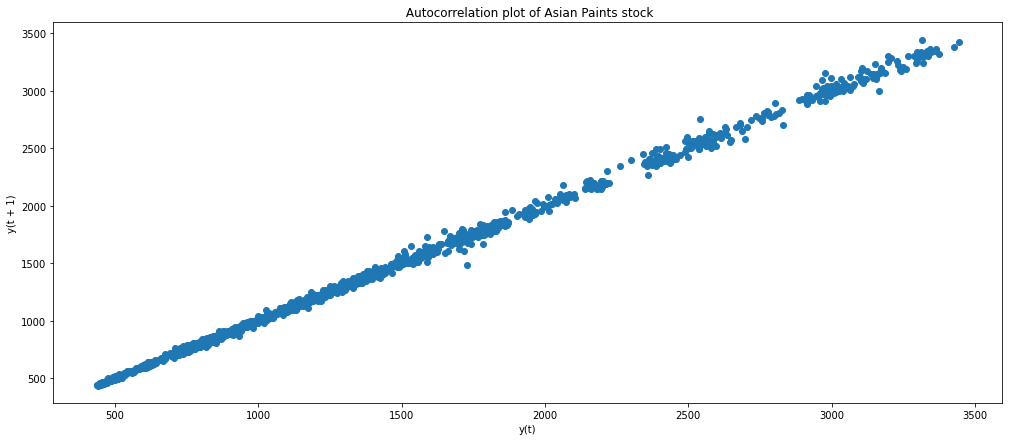

In [ ]:
# plt.figure(figsize=(17,7))
# lag_plot(tictic, lag=1)
# plt.title(' Autocorrelation plot of Asian Paints stock')

In [ ]:
# 12 month simple moving average and standard deviation
df['Production'].rolling(12).mean().plot(label='12 SMA',figsize=(16,8))
df1['Production'].rolling(12).std().plot(label='12 STD')
df1['Production'].plot()   # YOUR CODE HERE to plot 'Production' series
plt.legend()

Divide the data into train, test and split

In [ ]:
train_data, test_data = df_NSE[0:int(len(df_NSE)*0.8)], df_NSE[int(len(df_NSE)*0.8):]

In [ ]:
plt.figure(figsize=(17,7))
plt.title("Prices of Asian Paint stock")
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.plot(train_data['close'], 'blue', label = "Training Data")
plt.plot(test_data['close'], 'red', label = "Test Data")
plt.legend()
plt.show()

Plotting ACF and PACF plots to check ARIMA model order

In [ ]:
fig = plt.figure(fgsize=(15,7))
ax1 = fig.subplot(211)
fig = sm.graphics.tsa.plot_acf(diff, )